# 자연어 처리를 이용한 IMDB 영화 리뷰 감정 분석

- 캐글 **Bag of Words Meets Bags of Popcorn** 대회 
- 리뷰가 긍정인 경우 **1**을 부정인 경우 **0**

- [Reference]
    + 캐글 경진대회 : https://www.kaggle.com/c/word2vec-nlp-tutorial
    - 인프런 강의 : https://www.inflearn.com/course/nlp-imdb-%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EC%9E%90%EC%97%B0%EC%96%B4-%EC%B2%98%EB%A6%AC/dashboard

- 평가방법
    -  ROC 커브(Reciever-Operating Characteristic curve)
    - TPR( ), FPR( )
    - 민감도 TPR : 1인 케이스에 대해 1로 예측한 비율
    - 특이도 FPR : 0 인 케이스에 대해 1로 예측한 비율
    - ROC 커브의 밑 면적이 1에 가까울수록 (왼쪽 꼭지점에 다가갈수록) 좋은 성능을 낸다.
    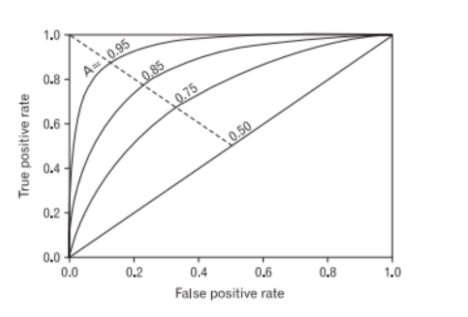

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# 코랩 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Part 1
NLP(자연어처리)는 텍스트 문제에 접근하기 위한 기술집합이다. 

이 튜토리얼에서는 IMDB 영화 리뷰를 로딩하고 정제하여 간단한 BOW(Bag Of Words)모델을 적용해서 리뷰가 추천인지 아닌지에 대한 정확도를 예측한다.

## 데이터 불러오기

In [ ]:
import pandas as pd

"""
header = 0 은 파일의 첫 번째 줄에 열 이름이 있음을 나타내며
delimiter = \t 는 필드가 탭으로 구분되는 것을 의미한다.
quoting = 3은 쌍따옴표를 무시하도록 한다.
"""
# QUOTE_MINIMAL (0), QUOTE_ALL (1),
# QUOTE_NONNUMERIC (2) or QUOTE_NONE (3).

# 레이블인 sentiment 가 있는 학습 데이터
train = pd.read_csv('/content/drive/MyDrive/labeledTrainData.tsv', header=0, delimiter='\t', quoting=3)
# 레이블이 없는 데스트 데이터
test = pd.read_csv('/content/drive/MyDrive/testData.tsv', header=0, delimiter='\t', quoting=3)

In [ ]:
train.shape

(25000, 3)

In [ ]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [ ]:
test.shape

(25000, 2)

In [ ]:
test.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [ ]:
train.columns.values

array(['id', 'sentiment', 'review'], dtype=object)

In [ ]:
# 레이블인 'sentiment'가 없다. 이 데이터를 머신러닝을 통해 예측한다.
test.columns.values

array(['id', 'review'], dtype=object)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
id           25000 non-null object
sentiment    25000 non-null int64
review       25000 non-null object
dtypes: int64(1), object(2)
memory usage: 586.0+ KB


In [ ]:
train.describe()

,sentiment
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [ ]:
train['sentiment'].value_counts()

1    12500
0    12500
Name: sentiment, dtype: int64

# 데이터 전처리 Data Cleaning and Text Preprocessing
- 토큰화 -> 불용어처리 -> 어간 추출 ->벡터화


기계가 텍스트를 이해할 수 있도록 텍스트를 정제해 준다.

신호와 소음을 구분한다. 아웃라이어데이터로 인한 오버피팅을 방지한다.

    1. BeautifulSoup을 통해 HTML 태그를 제거
    2. 정규표현식으로 알파벳 이외의 문자를 공백으로 치환
    3. 토큰화
    4. NLTK 데이터를 사용해 Stopword를 제거
    5. 어간추출(Stemming)과 음소표기법(Lemmatizing)의 개념을 이해하고 SnowballStemmer를 통해 어간을 추출
    




## 1. BeautifulSoup을 통해 HTML 태그를 제거

In [ ]:
# html 태그가 섞여있기 때문에 이를 정제해줄 필요가 있음
train['review'][0][:700]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely lik'

###### BeautifulSoup이 설치되지 않았다면 우선 설치
    !pip install bs4

In [ ]:
# 설치 및 버전확인
!pip3 show BeautifulSoup4

Name: beautifulsoup4
Version: 4.6.0
Summary: Screen-scraping library
Home-page: http://www.crummy.com/software/BeautifulSoup/bs4/
Author: Leonard Richardson
Author-email: leonardr@segfault.org
License: MIT
Location: /Users/macbook/anaconda3/lib/python3.6/site-packages
Requires: 
Required-by: bs4


In [ ]:
# review의 첫 번째 데이터의 HTML 태그 제거 
from bs4 import BeautifulSoup

example1 = BeautifulSoup(train['review'][0], "html5lib")
print(train['review'][0][:700])
example1.get_text()[:700]

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely lik


'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyw'

## 2. 정규표현식으로 알파벳 이외의 문자를 공백으로 치환

In [ ]:
# 정규표현식을 사용해서 특수문자를 제거
import re
# 소문자와 대문자가 아닌 것은 공백으로 대체한다.
# ^ : not을 의미
letters_only = re.sub('[^a-zA-z]', ' ', example1.get_text())
letters_only[:700]

' With all this stuff going down at the moment with MJ i ve started listening to his music  watching the odd documentary here and there  watched The Wiz and watched Moonwalker again  Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent  Moonwalker is part biography  part feature film which i remember going to see at the cinema when it was originally released  Some of it has subtle messages about MJ s feeling towards the press and also the obvious message of drugs are bad m kay Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyw'

## 3.토큰화

자연어 문서를 분석하기 위해서는 우선 긴 문자열을 분석을 위한 작은 단위로 나누어야 한다. 이 문자열 단위를 토큰(token)이라고 하고 이렇게 문자열을 토큰으로 나누는 작업을 토큰 생성(tokenizing)이라고 한다. 영문의 경우에는 문장, 단어 등을 토큰으로 사용하거나 정규 표현식을 쓸 수 있다.

문자열을 토큰으로 분리하는 함수를 토큰 생성 함수(tokenizer)라고 한다. 

In [ ]:
# 모두 소문자로 변환한다.
lower_case = letters_only.lower()
# 문자를 나눈다. => 토큰화
words = lower_case.split()
print(len(words))
words[:10]

437


['with',
 'all',
 'this',
 'stuff',
 'going',
 'down',
 'at',
 'the',
 'moment',
 'with']

##  4. NLTK 데이터를 사용해 Stopword를 제거

### 불용어 제거(Stopword Removal)

일반적으로 코퍼스에서 자주 나타나는 단어는 학습 모델로서 학습이나 예측 프로세스에 실제로 기여하지 않아 다른 텍스트와 구별하지 못한다. 예를들어 조사, 접미사, i, me, my, it, this, that, is, are 등 과 같은 단어는 빈번하게 등장하지만 실제 의미를 찾는데 큰 기여를 하지 않는다. Stopwords는 "to" 또는 "the"와 같은 용어를 포함하므로 사전 처리 단계에서 제거하는 것이 좋다. NLTK에는 179 개의 불용어가 미리 정의되어 있다. 17개의 언어에 대해 정의되어 있으며 한국어는 없다.

###### NLTK data 설치
http://corazzon.github.io/nltk_data_install

In [ ]:
pip install nltk

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords.words('english')[:10]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [ ]:
# stopwords 를 제거한 토큰들
words = [w for w in words if not w in stopwords.words('english')]
print(len(words))
words[:10]

219


['stuff',
 'going',
 'moment',
 'mj',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary']

## 5. SnowballStemmer를 통해 어간을 추출

### Stemming 어간추출, 형태소 분석

출처 : [어간 추출 - 위키백과](https://ko.wikipedia.org/wiki/%EC%96%B4%EA%B0%84_%EC%B6%94%EC%B6%9C)
- 어간 추출(語幹 抽出, 영어: stemming)은 어형이 변형된 단어로부터 접사 등을 제거하고 그 단어의 어간을 분리해 내는 것
- "message", "messages", "messaging" 과 같이 복수형, 진행형 등의 문자를 같은 의미의 단어로 다룰 수 있도록 도와준다.
- stemming(형태소 분석): 여기에서는 NLTK에서 제공하는 형태소 분석기를 사용한다. 포터 형태소 분석기는 보수적이고 랭커스터 형태소 분석기는 좀 더 적극적이다. 형태소 분석 규칙의 적극성 때문에 랭커스터 형태소 분석기는 더 많은 동음이의어 형태소를 생산한다. [참고 : 모두의 데이터 과학 with 파이썬(길벗)](http://www.gilbut.co.kr/book/bookView.aspx?bookcode=BN001787)

In [ ]:
# 포터 스태머의 사용 예
stemmer = nltk.stem.PorterStemmer()
print(stemmer.stem('maximum'))
print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(stemmer.stem("run")))

maximum
The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run


In [ ]:
# 랭커스터 스태머의 사용 예
from nltk.stem.lancaster import LancasterStemmer
lancaster_stemmer = LancasterStemmer()
print(lancaster_stemmer.stem('maximum'))
print("The stemmed form of running is: {}".format(lancaster_stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(lancaster_stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(lancaster_stemmer.stem("run")))

maxim
The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run


In [ ]:
# 처리 전 단어
words[:10]

['stuff',
 'going',
 'moment',
 'mj',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary']

In [ ]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')
words = [stemmer.stem(w) for w in words]

# 처리 후 단어
words[:10]

['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

### Lemmatization 음소표기법

언어학에서 음소 표기법 (또는 lemmatization)은 단어의 보조 정리 또는 사전 형식에 의해 식별되는 단일 항목으로 분석 될 수 있도록 굴절된 형태의 단어를 그룹화하는 과정이다. 예를 들어, 동음이의어가 문맥에 따라 다른 의미를 갖는데 

   1) *배*가 맛있다.
   
   2) *배*를 타는 것이 재미있다.
   
   3) 평소보다 두 *배*로 많이 먹어서 *배*가 아프다.
    
위에 있는 3개의 문장에 있는 "배"는 모두 다른 의미를 갖는다.

레미타이제이션은 이때 앞뒤 문맥을 보고 단어의 의미를 식별하는 것이다. 영어에서 meet은 meeting으로 쓰였을 때 회의를 뜻하지만 meet 일 때는 만나다는 뜻을 갖는데 그 단어가 명사로 쓰였는지 동사로 쓰였는지에 따라 적합한 의미를 갖도록 추출하는 것이다. 

- 참고 :
    - [Stemming and lemmatization](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)
    - [Lemmatisation - Wikipedia](https://en.wikipedia.org/wiki/Lemmatisation)

In [ ]:
import nltk
nltk.download('wordnet')

In [ ]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

print(wordnet_lemmatizer.lemmatize('fly'))
print(wordnet_lemmatizer.lemmatize('flies'))

words = [wordnet_lemmatizer.lemmatize(w) for w in words]

# 처리 후 단어
words[:10]

fly
fly


['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

## 문자열 처리
- 위에서 간략하게 살펴본 내용을 바탕으로 함수를 만들어 문자열을 처리해 본다.

In [ ]:
def review_to_words(raw_review):
    # 1. HTML 제거
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. 영문자가 아닌 문자는 공백으로 변환
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. 소문자 변환
    words = letters_only.lower().split()
    # 4. Stopwords를 세트로 변환
    # 파이썬에서는 리스트보다 세트로 찾는게 훨씬 빠르다.
    stops = set(stopwords.words('english'))
    # 5. Stopwords 제거
    meaningful_words = [w for w in words if not w in stops]
    # 6. 어간추출
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 7. 공백으로 구분된 문자열로 결합하여 결과를 반환
    return(' '.join(stemming_words))

In [ ]:
clean_review = review_to_words(train['review'][0])
clean_review

'stuff go moment mj start listen music watch odd documentari watch wiz watch moonwalk mayb want get certain insight guy thought realli cool eighti mayb make mind whether guilti innoc moonwalk part biographi part featur film rememb go see cinema origin releas subtl messag mj feel toward press also obvious messag drug bad kay visual impress cours michael jackson unless remot like mj anyway go hate find bore may call mj egotist consent make movi mj fan would say made fan true realli nice actual featur film bit final start minut exclud smooth crimin sequenc joe pesci convinc psychopath power drug lord want mj dead bad beyond mj overheard plan nah joe pesci charact rant want peopl know suppli drug etc dunno mayb hate mj music lot cool thing like mj turn car robot whole speed demon sequenc also director must patienc saint came film kiddi bad sequenc usual director hate work one kid let alon whole bunch perform complex danc scene bottom line movi peopl like mj one level anoth think peopl stay

## 벡터화 - BoW

### [Bag of words model - Wikipedia](https://en.wikipedia.org/wiki/Bag-of-words_model)

주머니 속에 단어들을 넣고 각 문장마다 구문 상관없이 단순히 주머니에 있는 단어들이 몇 번 나오는지 세어주는 방식이다.


다음의 두 문장이 있다고 하자.

    (1) John likes to watch movies. Mary likes movies too.
    (2) John also likes to watch football games.

위 두 문장을 토큰화 하여 가방에 담아주면 다음과 같다.

    ["John",
    "likes",
    "to",
    "watch",
    "movies",
    "Mary",
    "too",
    "also",
    "football",
    "games"]

그리고 배열의 순서대로 가방에서 각 토큰이 몇 번 등장하는지 횟수를 세어준다.

    (1) [1, 2, 1, 1, 2, 1, 1, 0, 0, 0]
    (2) [1, 1, 1, 1, 0, 0, 0, 1, 1, 1]

=> 머신러닝 알고리즘이 이해할 수 있는 형태로 바꿔주는 작업이다.



### N-gram

BoW기법은 단어의 갯수만을 벡터화하기 때문에 단어의 순서가 달려져도 같은 문장으로 인식한다는 한계가 있다. 이를 방지하기 위해 사용한다

단어 가방을 n-gram을 사용해 bigram 으로 담아주면 다음과 같다.

    ["John likes",
    "likes to",
    "to watch",
    "watch movies",
    "Mary likes",
    "likes movies",
    "movies too",]
    
=> 여기에서는 CountVectorizer를 통해 위 작업을 한다.

### **BoW기법 적용**

In [ ]:
# 첫 번째 리뷰를 대상으로 전처리 해줬던 내용을 전체 텍스트 데이터를 대상으로 처리한다.
# 전체 리뷰 데이터 수 가져오기
num_reviews = train['review'].size
num_reviews

25000

In [ ]:
clean_train_reviews = []
for i in range(0, num_reviews):
     if (i + 1) % 5000 == 0 :  #실행이 잘되는지 확인하기 위해 5000개 실행될때마다 확인문구
         print('Review {} of {}'.format(i+1, num_reviews))
     clean_train_reviews.append(review_to_words(train['review'][i]))

%time train['review_clean'] = train['review'].apply(review_to_words)

Review 5000 of 25000
Review 10000 of 25000
Review 15000 of 25000
Review 20000 of 25000
Review 25000 of 25000
CPU times: user 1min, sys: 688 ms, total: 1min
Wall time: 1min


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

# 튜토리얼과 다르게 파라미터 값을 수정
# 파라미터 값만 수정해도 캐글 스코어 차이가 많이 남
vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = None,
                             preprocessor = None, 
                             stop_words = None, 
                             min_df = 2, # 토큰이 나타날 최소 문서 개수
                             ngram_range=(1, 3),
                             max_features = 5000)
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=5000, min_df=2,
                ngram_range=(1, 3), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [ ]:
train_data_features = vectorizer.fit_transform(clean_train_reviews)
train_data_features.shape

(25000, 5000)

In [ ]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

5000


['abandon',
 'abc',
 'abil',
 'abl',
 'abort',
 'abraham',
 'abrupt',
 'absenc',
 'absolut',
 'absolut love']

In [ ]:
# 벡터화 된 feature를 확인해 봄
import numpy as np
dist = np.sum(train_data_features, axis=0)
    
for tag, count in zip(vocab, dist):
    print(count, tag)

# 전체 데이터의 counts를 모두 sum한 결과
pd.DataFrame(dist, columns=vocab)

[[ 288  125  562 ... 1331   89  161]] abandon


,abandon,abc,abil,abl,abort,abraham,abrupt,absenc,absolut,absolut love,absolut noth,absorb,absurd,abus,abysm,academi,academi award,accent,accept,access,accid,accident,acclaim,accompani,accomplish,accord,account,accur,accus,achiev,acid,acknowledg,acquir,across,act,act abil,act bad,act direct,act film,act good,...,wrestl,write,write direct,write review,writer,writer director,written,written direct,wrong,wrote,wwii,ya,yard,yawn,yeah,year,year ago,year earlier,year later,year old,yell,yellow,yes,yesterday,yet,yet anoth,york,york citi,young,young boy,young girl,young man,young peopl,young woman,younger,youth,zero,zombi,zombi movi,zone
0,288,125,562,1259,92,93,136,118,1850,93,154,154,427,398,110,298,172,704,781,165,344,246,118,197,271,329,297,349,204,578,102,109,97,971,8794,90,244,98,101,174,...,125,2096,91,90,1814,327,1616,108,1910,574,158,103,105,94,462,6888,660,120,488,1261,191,113,1535,119,2753,240,812,164,3664,136,199,233,92,236,504,364,390,1331,89,161


### **Random Forest**

### [랜덤 포레스트 - 위키백과](https://ko.wikipedia.org/wiki/%EB%9E%9C%EB%8D%A4_%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8)

랜덤 포레스트의 가장 핵심적인 특징은 임의성(randomness)에 의해 서로 조금씩 다른 특성을 갖는 트리들로 구성된다는 점이다. 이 특징은 각 트리들의 예측(prediction)들이 비상관화(decorrelation) 되게하며, 결과적으로 일반화(generalization) 성능을 향상시킨다. 또한, 임의화(randomization)는 포레스트가 노이즈가 포함된 데이터에 대해서도 강인하게 만들어 준다.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)

forest

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=2018, verbose=0,
                       warm_start=False)

In [ ]:
%time forest = forest.fit(train_data_features, train['sentiment'])

CPU times: user 1min 30s, sys: 108 ms, total: 1min 30s
Wall time: 46.1 s


In [ ]:
from sklearn.model_selection import cross_val_score
%time score = np.mean(cross_val_score(\
    forest, train_data_features, \
    train['sentiment'], cv=10, scoring='roc_auc'))
score

CPU times: user 10.1 s, sys: 1.19 s, total: 11.3 s
Wall time: 6min 44s


0.922193088

In [ ]:
score

0.922193088

In [ ]:
clean_test_reviews = []
for i in range(0, num_reviews):
     if (i + 1) % 5000 == 0 :  #실행이 잘되는지 확인하기 위해 5000개 실행될때마다 확인문구
         print('Review {} of {}'.format(i+1, num_reviews))
     clean_test_reviews.append(review_to_words(test['review'][i]))

Review 5000 of 25000
Review 10000 of 25000
Review 15000 of 25000
Review 20000 of 25000
Review 25000 of 25000


In [ ]:
test_data_features = vectorizer.fit_transform(clean_test_reviews)
test_data_features = test_data_features.toarray()

In [ ]:
result = forest.predict(test_data_features)

In [ ]:
output = pd.DataFrame(data={"id":test["id"], "sentiment" : result, "review":test["review"]})
output    # kaggle score : 0.85360

,id,sentiment,review
0,"""12311_10""",0,"""Naturally in a film who's main themes are of ..."
1,"""8348_2""",0,"""This movie is a disaster within a disaster fi..."
2,"""5828_4""",0,"""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""",1,"""Afraid of the Dark left me with the impressio..."
4,"""12128_7""",0,"""A very accurate depiction of small time mob l..."
...,...,...,...
24995,"""2155_10""",0,"""Sony Pictures Classics, I'm looking at you! S..."
24996,"""59_10""",0,"""I always felt that Ms. Merkerson had never go..."
24997,"""2531_1""",0,"""I was so disappointed in this movie. I am ver..."
24998,"""7772_8""",1,"""From the opening sequence, filled with black ..."


In [ ]:
output_sentiment = output['sentiment'].value_counts()
print(output_sentiment[0] - output_sentiment[1])
output_sentiment

108


0    12554
1    12446
Name: sentiment, dtype: int64

### [추가] 워드 클라우드
- 단어의 빈도 수 데이터를 가지고 있을 때 이용할 수 있는 시각화 방법
- 단순히 빈도 수를 표현하기 보다는 상관관계나 유사도 등으로 배치하는 게 더 의미 있기 때문에 큰 정보를 얻기는 어렵다.

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
# %matplotlib inline 설정을 해주어야지만 노트북 안에 그래프가 디스플레이 된다.
%matplotlib inline

def displayWordCloud(data = None, backgroundcolor = 'white', width=800, height=600 ):
    wordcloud = WordCloud(stopwords = STOPWORDS, 
                          background_color = backgroundcolor, 
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15 , 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

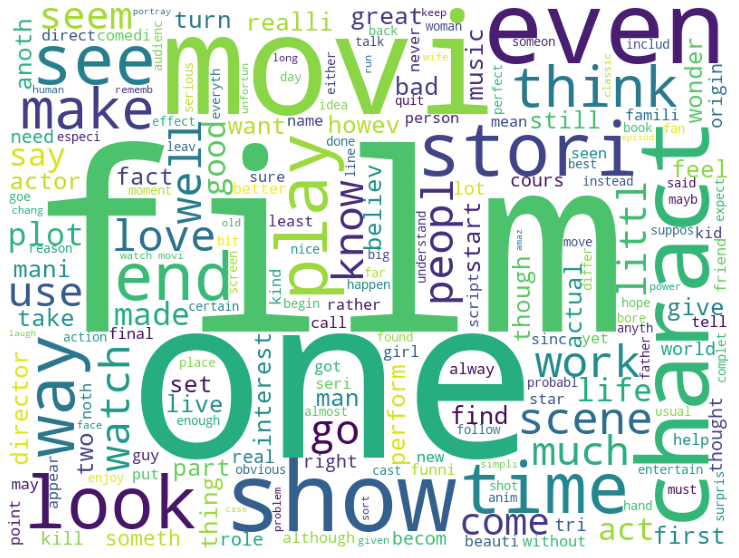

CPU times: user 21.3 s, sys: 797 ms, total: 22.1 s
Wall time: 22.1 s


In [ ]:
# train 데이터의 모든 단어에 대한 워드 클라우드를 그려본다.
%time displayWordCloud(' '.join(clean_train_reviews))

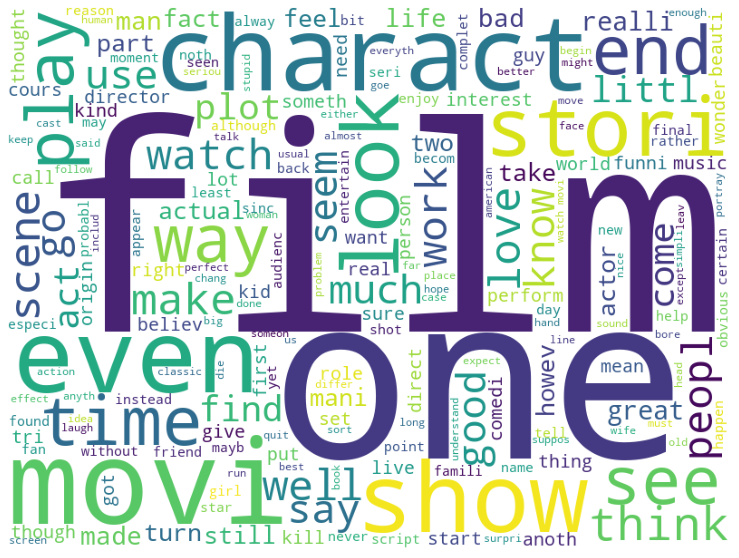

CPU times: user 21.2 s, sys: 614 ms, total: 21.8 s
Wall time: 21.9 s


In [ ]:
# test 데이터의 모든 단어에 대한 워드 클라우드를 그려본다.
%time displayWordCloud(' '.join(clean_test_reviews))

In [ ]:
# 단어 수
train['num_words'] = clean_train_reviews.apply(lambda x: len(str(x).split()))
# 중복을 제거한 단어 수
train['num_uniq_words'] = clean_train_reviews.apply(lambda x: len(set(str(x).split())))

In [ ]:
# 첫 번째 리뷰에 
x = clean_train_reviews[0]
x = str(x).split()
print(len(x))
x[:10]

219


['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

리뷰별 단어 평균 값 : 119.52356
리뷰별 단어 중간 값 89.0
리뷰별 고유 단어 평균 값 : 94.05756
리뷰별 고유 단어 중간 값 74.0


/Users/macbook/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'리뷰별 고유한 단어 수 분포')

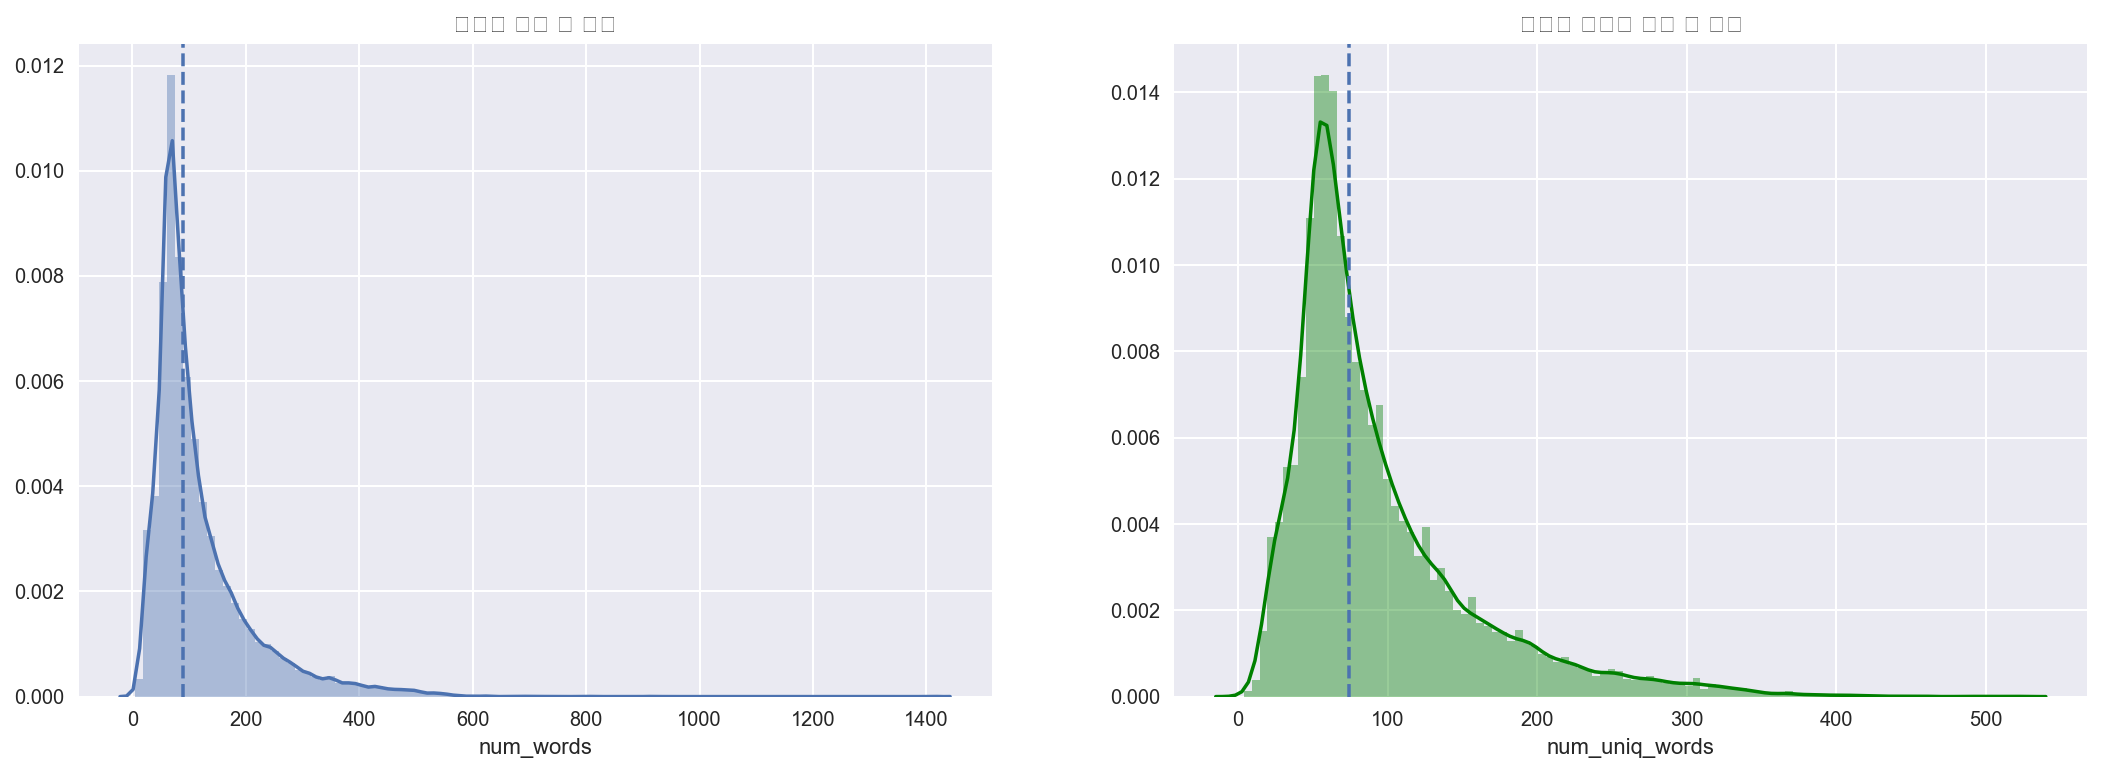

In [ ]:
import seaborn as sns

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(18, 6)
print('리뷰별 단어 평균 값 :', train['num_words'].mean())
print('리뷰별 단어 중간 값', train['num_words'].median())
sns.distplot(train['num_words'], bins=100, ax=axes[0])
axes[0].axvline(train['num_words'].median(), linestyle='dashed')
axes[0].set_title('리뷰별 단어 수 분포')

print('리뷰별 고유 단어 평균 값 :', train['num_uniq_words'].mean())
print('리뷰별 고유 단어 중간 값', train['num_uniq_words'].median())
sns.distplot(train['num_uniq_words'], bins=100, color='g', ax=axes[1])
axes[1].axvline(train['num_uniq_words'].median(), linestyle='dashed')
axes[1].set_title('리뷰별 고유한 단어 수 분포')

### ☆ Scikit-Learn의 CountVectorizer를 통해 feature 생성

- 정규표현식을 사용해 토큰을 추출한다.
- 모두 소문자로 변환시키기 때문에 good, Good, gOod이 모두 같은 특성이 된다.
- 의미없는 특성을 많이 생성하기 때문에 적어도 두 개의 문서에 나타난 토큰만을 사용한다.
- min_df로 토큰이 나타날 최소 문서 개수를 지정할 수 있다.

### ☆ CountVectorizer의 인수

- `stop_words` : 문자열 {‘english’}, 리스트 또는 None (디폴트)
    - stop words 목록.‘english’이면 영어용 스탑 워드 사용.
- `analyzer` : 문자열 {‘word’, ‘char’, ‘char_wb’} 또는 함수
    - 단어 n-그램, 문자 n-그램, 단어 내의 문자 n-그램
- `token_pattern` : string
    - 토큰 정의용 정규 표현식
- `tokenizer` : 함수 또는 None (디폴트)
    - 토큰 생성 함수 .
- `ngram_range` : (min_n, max_n) 튜플
    - n-그램 범위
- `max_df` : 정수 또는 [0.0, 1.0] 사이의 실수. 디폴트 1
    - 단어장에 포함되기 위한 최대 빈도
- `min_df` : 정수 또는 [0.0, 1.0] 사이의 실수. 디폴트 1
    - 단어장에 포함되기 위한 최소 빈도

### ☆ 텍스트 데이터 전처리 용어
(출처: https://github.com/twitter/twitter-korean-text/)

**정규화 normalization (입니닼ㅋㅋ -> 입니다 ㅋㅋ, 샤릉해 -> 사랑해)**

- 한국어를 처리하는 예시입니닼ㅋㅋㅋㅋㅋ -> 한국어를 처리하는 예시입니다 ㅋㅋ

**토큰화 tokenization**

- 한국어를 처리하는 예시입니다 ㅋㅋ -> 한국어Noun, 를Josa, 처리Noun, 하는Verb, 예시Noun, 입Adjective, 니다Eomi ㅋㅋKoreanParticle

**어근화 stemming (입니다 -> 이다)**

- 한국어를 처리하는 예시입니다 ㅋㅋ -> 한국어Noun, 를Josa, 처리Noun, 하다Verb, 예시Noun, 이다Adjective, ㅋㅋKoreanParticle

**어구 추출 phrase extraction**

- 한국어를 처리하는 예시입니다 ㅋㅋ -> 한국어, 처리, 예시, 처리하는 예시